앞 절에서 구현한 계층들을 조합하면 마치 레고 블록을 조합하듯 신경망을 구축할 수 있다.<br>
이번 절에서는 지금까지 구현한 계층을 조합해서 신경망을 구축해보자.

# 5.7.1 신경망 학습의 전체 그림

내용이 길어졌으니, 구체적인 구현에 앞서 신경망 학습의 전체 그림을 복습해보자. 다음은 신경망 학습의 순서이다.
#### 전제
신경망에는 적응 가능한 가중치와 편향이 있고, 이 가중치와 편향을 훈련 데이터에 적응하도록 조정하는 과정을 "학습"이라고 한다. 신경망 학습은 다음과 같이 4단계로 수행한다.
#### 1단계 - 미니배치
훈련 데이터 중 일부를 무작위로 가져온다. 이렇게 선별한 데이터를 미니배치라 하며, 그 미니배치의 손실 함수 값을 줄이는 것이 목표이다.
#### 2단계 - 기울기 산출
미니배치의 손실 함수 값을 줄이기 위해 각 가중치 매개변수의 기울기를 구한다. 기울기는 손실 함수의 값을 가장 작게 하는 방향을 제시한다.
#### 3단계 - 매개변수 갱신
가중치 매개변수를 기울기 방향으로 아주 조금 갱신한다.
#### 4단계 - 반복
1~3단계를 반복한다.

지금까지 설명한 오차역전파법이 등장하는 단계는 2단계인 "기울기 산출"이다. 수치 미분은 구현하기는 쉽지만 계산은 오래 걸렸다. 하지만 오차역전파법은 효율적이고 빠르게 기울기를 구할 수 있다.

# 5.7.2 오차역전파법을 적용한 신경망 구현하기

여기에서는 2층 신경망을 TwoLayerNet 클래스로 구현한다.<br>
우선은 이 클래스의 인스턴스 변수와 메소드를 정리한 표를 보자.

<img src=images/5_31.png height=100px width=500px>

In [1]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from functions import *
from Layers import *
from collections import OrderedDict

class TwoLayerNet:
    
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        
        ## 파리미터 초기화
        self.params = {}
        self.params["W1"] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params["W2"] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params["b1"] = np.zeros(hidden_size)
        self.params["b2"] = np.zeros(output_size)
        
        ## 계층 생성
        self.layers = OrderedDict()
        self.layers["Affine1"] = AffineLayer(self.params["W1"], self.params["b1"])
        self.layers["ReLU"] = ReLULayer()
        self.layers["Affine2"] = AffineLayer(self.params["W2"], self.params["b2"])
        self.lastlayer = SoftmaxLossLayer()
                
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
    
    def loss(self, x, t):
        y = self.predict(x)
        
        return self.lastlayer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        
        if t.ndim != 1:
            t = np.argmax(t, axis=1)
            
        acc = np.sum(y == t) / float(x.shape[0])
        
        return acc
    
    def numerical_gradient(self, x, t):
        loss_W = lambda W:self.loss(x, t)
        
        grads = {}
        grads["W1"] = numerical_gradient(loss_W, self.params["W1"])
        grads["W2"] = numerical_gradient(loss_W, self.params["W2"])
        grads["b1"] = numerical_gradient(loss_W, self.params["b1"])
        grads["b2"] = numerical_gradient(loss_W, self.params["b2"])
        
        return grads
    
    def gradient(self, x, t):
        
        ## 순전파
        self.loss(x, t)
        
        ## 역전파
        dout = 1
        dout = self.lastlayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
            
        grads = {}
        grads["W1"] = self.layers["Affine1"].dW
        grads["b1"] = self.layers["Affine1"].db
        grads["W2"] = self.layers["Affine2"].dW
        grads["b2"] = self.layers["Affine2"].db
        
        return grads

여기서 OrderedDict란 순서가 있는 딕셔너리로, 딕셔너리에 추가한 순서를 기억하는 딕셔너리이다. 따라서 순전파 때는 추가한 순서대로 각 계층의 forward()메소드를 호출하면 완료된다. 마찬가지로 역전파 때는 계층을 반대 순서로 호출하기만 하면 된다. Affine 계층과 ReLU 계층이 각자의 내부에서 순전파와 역전파를 제대로 처리하고 있으니, 여기에서는 그냥 계층을 올바른 순서로 연결한 다음 수서대로(혹은 역순으로) 호출해주면 끝이다. 이처럼 신경망의 구성 요소를 "계층"으로 구현한 덕분에 신경망을 쉽게 구축할 수 있고, 층이 많아진다 하더라도 층을 층을 추가하기만 하면 되는 간단한 과정을 거치면 된다.(레고를 조립하듯이)

# 5.7.3 오차역전파법으로 구한 기울기 검증하기

지금까지 기울기를 구하는 방법을 두 가지 설명하였다. 하나는 수치 미분이고, 다른 하나는 오차역전파법이다. 수치 미분은 간단하고 정확한 대신 오래걸리는 단점이 있고, 오차역전파법은 빠르고 효율적인 대신 복잡성에 의해 오류가 있을 가능성이 있다. 따라서 수치 미분 결과와 오차역전파법의 결과를 비교하여 오차역전파법을 제대로 구현했는지 검증하곤 한다.<br>
이 기울기 검증을 구현해보자.

In [2]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from source.dataset.mnist import load_mnist

## 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

for key in grad_numerical.keys():
    diff = np.average(np.abs(grad_numerical[key] - grad_backprop[key]))
    print(f"{key}: {diff}")

W1: 1.737514688054628e-13
W2: 7.224250211988834e-13
b1: 8.307168592337072e-13
b2: 1.201261340399995e-10


# 5.7.4 오차역전파법을 사용한 학습 구현하기

마지막으로 오차역전파법을 사용한 신경망 학습을 구현해보자. 지금까지와 다른 부분은 기울기를 오차역전파법으로 구한다는 점뿐이다. 

In [3]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from source.dataset.mnist import load_mnist

## 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grad = network.gradient(x_batch, t_batch)
    
    ## 갱신
    for key in ("W1", "b1", "W2", "b2"):
        network.params[key] -= learning_rate * grad[key]
        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if (i % iter_per_epoch) == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(f"epoch={int(i // iter_per_epoch)+1}: {np.round(train_acc, 4)}, \
        epoch={int(i // iter_per_epoch)+1}: {np.round(test_acc, 4)}")

epoch=1: 0.1122,         epoch=1: 0.116
epoch=2: 0.9038,         epoch=2: 0.9069
epoch=3: 0.9228,         epoch=3: 0.9246
epoch=4: 0.9359,         epoch=4: 0.9356
epoch=5: 0.9429,         epoch=5: 0.9392
epoch=6: 0.9505,         epoch=6: 0.9457
epoch=7: 0.9547,         epoch=7: 0.9498
epoch=8: 0.9602,         epoch=8: 0.9548
epoch=9: 0.9616,         epoch=9: 0.9559
epoch=10: 0.9662,         epoch=10: 0.9589
epoch=11: 0.969,         epoch=11: 0.9625
epoch=12: 0.9712,         epoch=12: 0.964
epoch=13: 0.9728,         epoch=13: 0.966
epoch=14: 0.9737,         epoch=14: 0.9645
epoch=15: 0.9756,         epoch=15: 0.9669
epoch=16: 0.9774,         epoch=16: 0.9688
epoch=17: 0.9787,         epoch=17: 0.9713


정확도의 추이를 시각화 해보자.

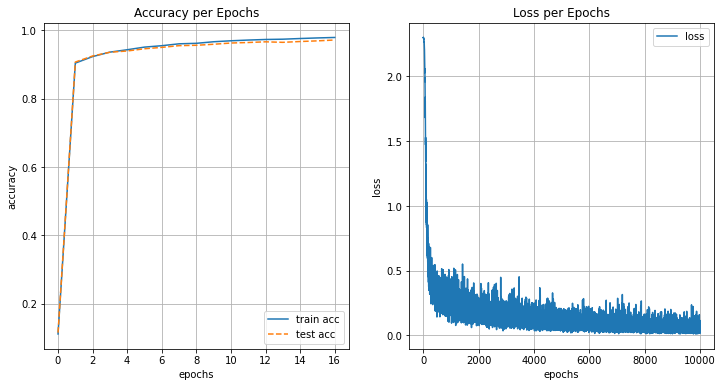

In [4]:
import matplotlib.pyplot as plt

epochs = np.arange(len(train_acc_list))
iters = np.arange(len(train_loss_list))

plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.plot(epochs, train_acc_list, label="train acc")
plt.plot(epochs, test_acc_list, label="test acc", linestyle="--")
plt.title("Accuracy per Epochs")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.grid()

plt.subplot(122)
plt.plot(iters, train_loss_list, label="loss")
plt.title("Loss per Epochs")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.grid()

plt.show()

그래프에서 볼 수 있듯이 어느 한 데이터셋에 과도하게 적응하지 않고 고루고루 높은 점수를 보여주고 있다. 즉, 오버피팅이 일어나지 않았다.